<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>

</center>

# Utilisation de modèles d'Arbres de Décision pour un problème d'Adaptation Statistique d'un Modèle de Prévision du Pic d'Ozone en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-learn"/></a>

## Résumé 
Exploration et modélisation de données climatiques avec la librairie [Scikit-learn](http://scikit-learn.org/stable/#) en Python. 

L'objectif est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales. La méthode de sélection de paramètres par validation croisée sera utilisée pour optimiser les différents modèles expérimentés. Les différents modèles seront ensuites testés et comparés par rapport à différentes [erreurs de prévision](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf) sur un échantillon test puis des courbes ROC.

#### Partie 1
L'estimation se fera par des méthodes d'[arbres de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf). Nous comparerons notamment deux approches possibles pour ce problème: 
- Prédiction de la valeur de la concentration d'ozone par Arbre de Régression, puis seuillage pour prédire le dépassement.
- Prédiction direct du dépassement par Arbre de Classification.

Les comparaisons des différents  sur un échantillon test puis des courbes ROC.  Ce calepin vient compléter l'étude faite avec R disponible sur Moodle pour en comparer les deux approches.

#### Partie 2
Dans un deuxième temps, des approches d'[agrégation de modèle](http://wikistat.fr/pdf/st-m-app-agreg.pdf) seront expérimentés.
\
\
**Remarque**: Ce calepin vient compléter l'étude faite avec R, disponible sur Moodle. Les résultats obtenus et temps d'exécutions pourront être comparés.

## Présentation du problème

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* ou post-traitement d'une prévision locale de modèles à trop grande échelle en s'aidant d'autre variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). 

La question posée est: quelle est la meilleure stratégie pour prévoir l'occurrence d'un pic de pollution?

Dans ce calepin, les méthodes sont testées sont uniquement: 
- [Arbres de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), 
- [Agrégation d'Arbres](http://wikistat.fr/pdf/st-m-app-agreg.pdf) (bagging, boosting, random forest). 
Voir le notebook du même nom sur wikistat pour une comparaison beaucoup plus complète. L'objectif final, à ne pas perdre de vue, est la comparaison de ces méthodes afin de déterminer la plus efficace pour répondre au problème de prévision. Ceci passe par la mise en place d'un protocole très strict afin de s'assurer d'un minimum d'objectivité pour cette comparaison.

De façon générale on suppose que l'utilisateur dispose d'une installation python à jour. Le calepin a été testé avec la version 3.8.

## Présentation des données

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes:


* **JOUR** Le type de jour ; férié (1) ou pas (0) ;
* **O3obs** La concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** Prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** Température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** Rapport d'humidité ;
* **NO2** Concentration en dioxyde d'azote ;
* **NO** Concentration en monoxyde d'azote ;
* **STATION** Lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** Force du vent ;
* **VentANG** Orientation du vent. 

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent avant tout un caractère pédagogique.

#### Lecture des données
Il est choisi ici de lire les données avec la librairie `pandas` pour bénéficier de la classe DataFrame. Ce n'est pas nécessaire pour l'objectif de prévision car les variables qualitatives ainsi construites ne peuvent être utilisées pour l'interprétation des modèles obtenus dans `scikit-learn` qui ne reconnaît pas la classe DataFrame.

In [26]:
import pandas as pd
import numpy as np

path = ""
ozone = pd.read_csv(path+"depSeuil.dat", sep=",", header=0)

In [27]:
# Vérification du contenu
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
0,1,91,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
1,1,100,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
2,0,82,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
3,0,94,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
4,0,107,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822


In [28]:
# Statistiques du contenu
ozone.describe(include="all")

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041,1041.000000,1041.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Als,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222,NaN,NaN
mean,0.304515,115.400576,127.219693,23.883381,0.010251,3.504645,0.657417,NaN,5.907186,0.163111
std,0.460423,40.999155,39.820186,5.217462,0.003731,4.043308,0.844180,NaN,3.054307,0.708288
min,0.000000,19.000000,46.400000,10.400000,0.002850,0.258000,0.001000,NaN,0.141420,-1.570790
25%,0.000000,87.000000,97.500000,20.200000,0.007630,1.248000,0.236000,NaN,3.962320,-0.394790
50%,0.000000,109.000000,125.600000,23.800000,0.009850,2.109000,0.388000,NaN,5.597300,0.278300
75%,1.000000,135.000000,153.600000,27.600000,0.012440,4.062000,0.744000,NaN,7.106300,0.692640


## Exploration des données

Même si les données ne présentent pas de défauts particuliers, une étude exploratoire préliminaire est indispensable afin de s'assurer le leur bonne cohérence, proposer d'éventuelles transformations et analyser les structures de corrélations ou plus généralement de liaisons entre les variables, de groupes des individus ou observations.

#### Unidimensionnelle

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

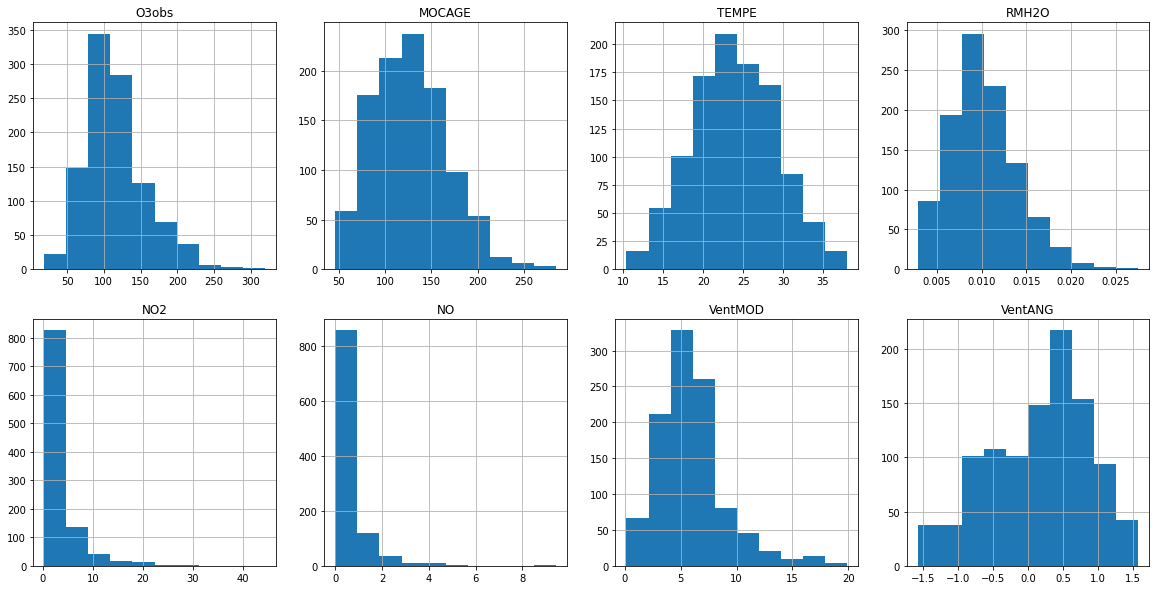

In [30]:
cols = ["O3obs", "MOCAGE", "TEMPE", "RMH2O", "NO2", "NO", "VentMOD", "VentANG"]

plt.figure(figsize=(20,10))
for i in range(len(cols)):
    plt.subplot(2, 4, i+1)
    plt.title(cols[i])
    ozone[cols[i]].hist()
plt.show()

On propose les transformations suivantes afin de rendre les données plus symétriques:
- prendre la racine carré de la variable MH2O
- prendre le log de NO2 et NO

**Q** Appliquer ces transformations et vérifier si les histogrammes des nouvelles variables sont bien plus symmétriques. 

__Remarque__: On ne transformera pas tout de suite les données car un _pipeline_ générique de transformation des données brutes sera construit plus tard.

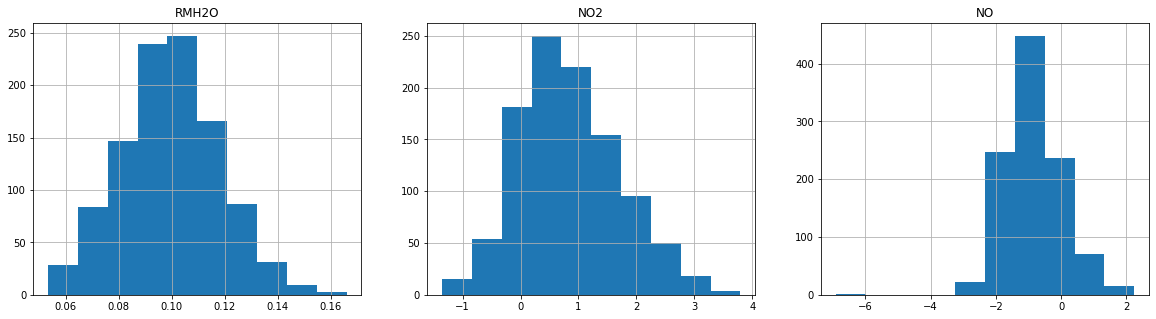

In [31]:
cols = ["RMH2O", "NO2", "NO"]
transformations = [np.sqrt, np.log, np.log]
plt.figure(figsize=(20,5))
for i in range(len(cols)):
    plt.subplot(1, 3, i+1)
    plt.title(cols[i])
    transformations[i](ozone[cols[i]]).hist()
plt.show()

#### Multidimensionnelle

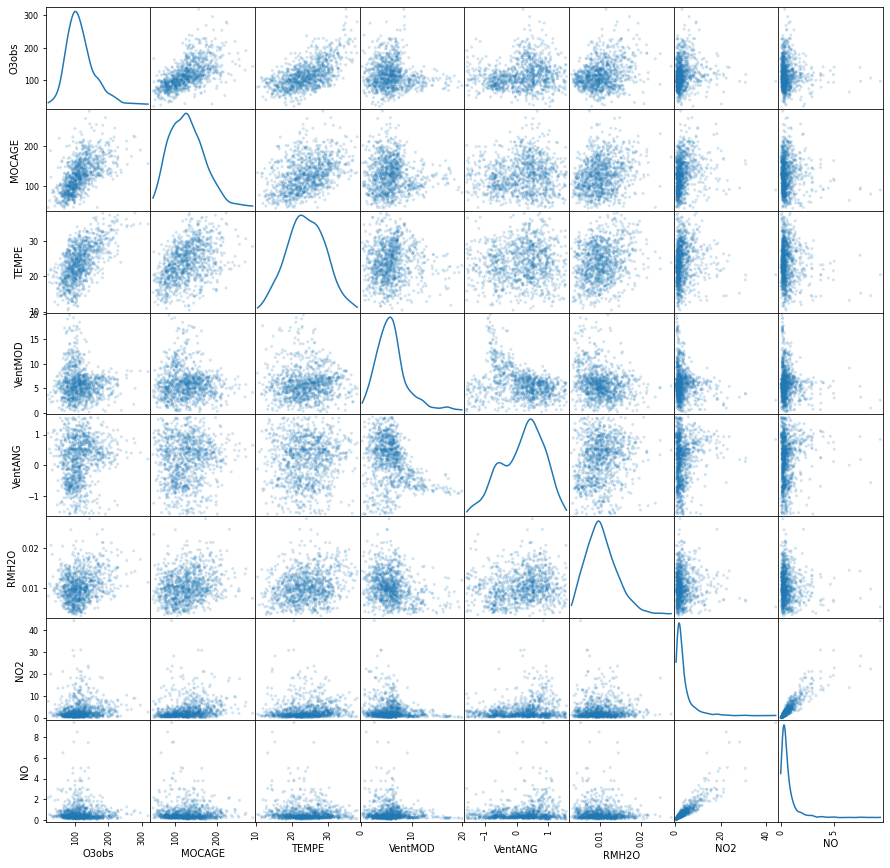

In [32]:
# scatter plot matrix des variables quantitatives
from pandas.plotting import scatter_matrix
scatter_matrix(ozone[["O3obs","MOCAGE","TEMPE","VentMOD","VentANG","RMH2O","NO2","NO"]], 
               alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

**Q** Commenter les relations entre les variables prises 2 à 2.

NO2 et NO sont corrélés

## Protocole de comparaison

#### Stratégie

La recherche  d'une meilleure méthode de prévision suit généralement le protocole suivant dont la première étape est déja réalisée.


1. Etape descriptive préliminaire uni et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données. 
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par [*validation croisée*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf).
    - Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
    - variables et méthode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de régression ou de classification;
    - architecture (nombre de neurones, pénalisation) du perceptron;
    - algorithme d'agrégation, 
    - noyau et pénalisation des SVMs.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.

**Remarques**
* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test ([validation croisée *Monte Carlo*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)), afin de réduire la variance (moyenne) des estimations des erreurs de prévision.
* *Attention*: ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test !
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...
* L'étape "choix" de la meilleure méthode peut être remplacée par une combinaisons de prévision comme c'est souvent le cas dans les soutions "gagnantes" mais lourdes du site [kaggle](https://www.kaggle.com/competitions).

## Extraction des échantillons apprentissage et test

#### Transformation des données pour l'apprentissage

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer


oh_encoder = OneHotEncoder(drop="if_binary")  # Builds a onehot encoder, when only two values keep a single column.
no_transformer = FunctionTransformer(lambda x: x)  # No transformation, the data is simply copied
log_transformer = FunctionTransformer(np.log)  # Log transform the data
sqrt_transformer = FunctionTransformer(np.log)  # Square root transform the data

ct = ColumnTransformer([("onehot", oh_encoder, [0, 7]),  # oh_encoder is applied to columns 0 and 7
                        ("identity", no_transformer, [2, 3, 8, 9]),
                        ("sqrt", sqrt_transformer, [4]),
                        ("log", log_transformer , [5, 6])])

X_names = ["JOUR", "STATION_Aix", "STATION_Als", "STATION_Cad", "STATION_Pla", "STATION_Ram",
         "MOCAGE", "TEMPE", "VentMOD", "VentANG", "MH2O", "NO2", "NO"]

#print(ct.fit_transform(ozone)[0, :])

In [34]:
# Variables d'entrée
X = ct.fit_transform(ozone)

# Variable à expliquer binaire
Yb = FunctionTransformer(lambda x: x > 150).fit_transform(ozone["O3obs"])

# variable à expliquer réelle
Yr = ozone["O3obs"]

**Q** Pourquoi les variables qualitatives sont-elles transformées en paquets d'indicatrices ou *dummy variables*?

L'algo Python contrairement a R n'accepte pas les variables qualitatives.
On effectue donc une transformation (`OneHotEncoder`), par exemple avec les Station, pour qu'il puisse acceptés les variables.

#### Séparation de l'échantillon de test pour les deux types de modèles. 
Comme le générateur est initalisé de façon identique, ce sont les mêmes échantillons dans les deux cas.

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, Yb_train, Yb_test = train_test_split(X, Yb, test_size=200, random_state=11)
_,       _,      Yr_train, Yr_test = train_test_split(X, Yr, test_size=200, random_state=11)

## Entrainement des Arbres binaires de décision (classification/regression)

Nous allons essayer deux approches pour optimiser les arbres en Python:
- Optimisation de paramètres tels que la profondeur de l'arbre ou le nombre d'échantillon minimum par feuille.
- Comme en R, nous utiliserons également la méthode de *pénalisation* de la *complexité*.

Comme précédemment, la validation croisée permet d'optimiser le paramètre sur une grille.

#### Arbre de classification

**Q** Mettre en place une validation croisée sur le jeu d'entraînement pour sélectioner la profondeur maximale, le critère de séparation, le nombre minimal d'échantillon par feuille

Meilleur score = 0.129636, Meilleur paramètre = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4}


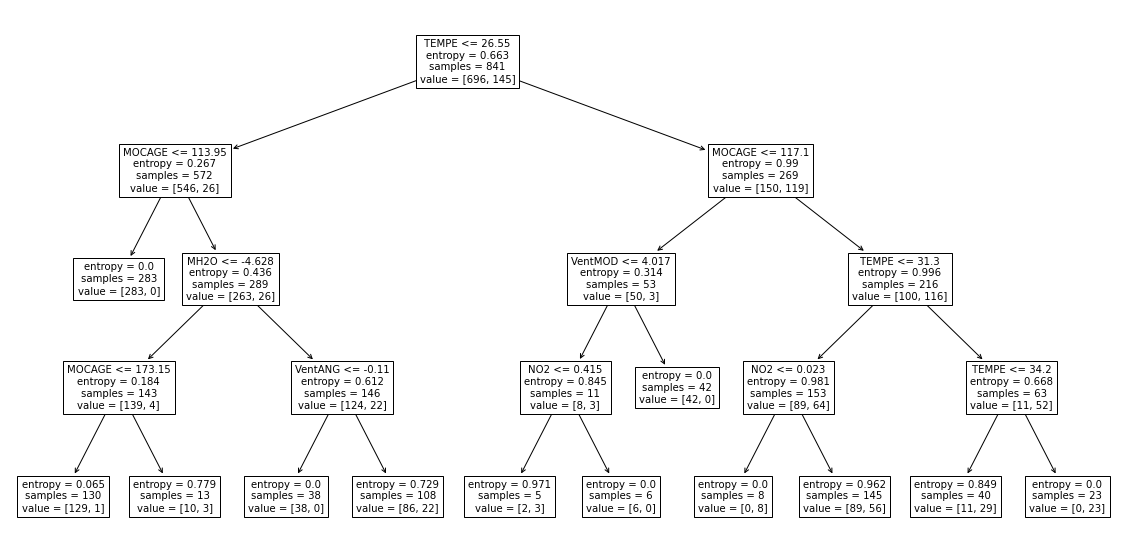

In [36]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV

# Optimisation de la profondeur de l'arbre, 
#              du critère d'optimisation, et 
#              du nombre minimum d'échantillon par feuille.
param = [{"max_depth":list(range(2,10)), 
          "criterion":["gini", "entropy"], 
          "min_samples_leaf":list(range(2,10))}]

tree = GridSearchCV(DecisionTreeClassifier(), param, cv=10, n_jobs=-1)
treeOpt = tree.fit(X_train, Yb_train)

# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

# Arbre final
tree = treeOpt.best_estimator_

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_names)
plt.show()

#### Afficher la matrice de confusion

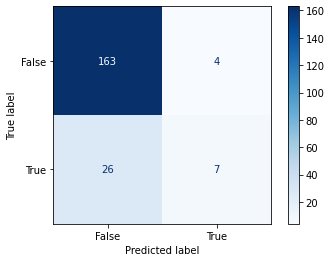

In [37]:
# Display confusion matrix for the test set

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(tree, X_test, Yb_test, cmap=plt.cm.Blues)
plt.show()

**Q**: Reproduire la recherche de paramètre pour le critère de coût complexité

Meilleur score = 0.129678, Meilleur paramètre = {'ccp_alpha': 0.004, 'criterion': 'gini'}


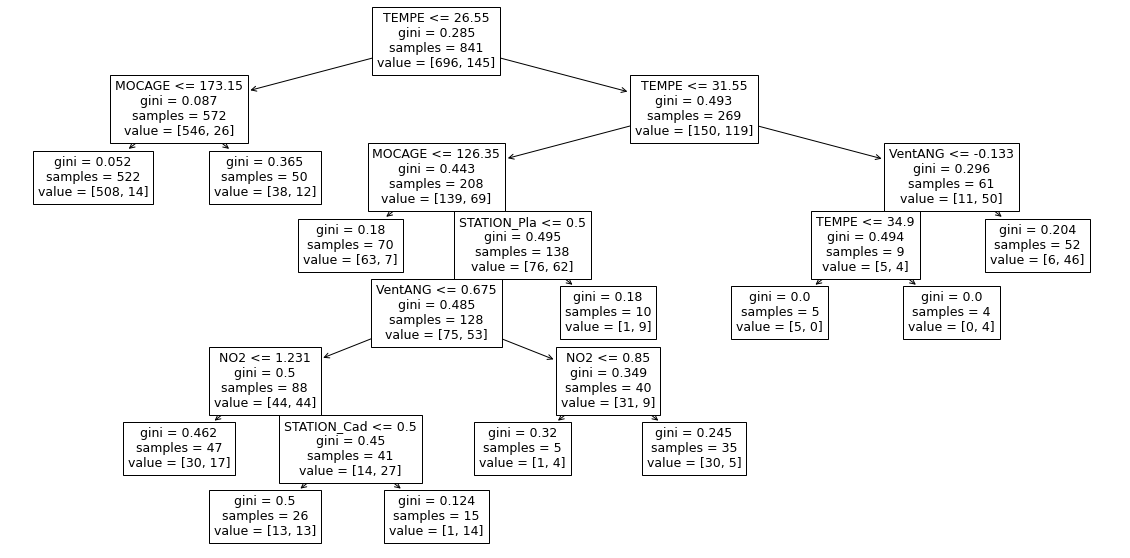

In [38]:
param = [{"criterion": ["gini", "entropy"],
          "ccp_alpha": list(np.arange(0.001,0.01, 0.001))}]

tree = GridSearchCV(DecisionTreeClassifier(), param, cv=10, n_jobs=-1)
treeOpt = tree.fit(X_train, Yb_train)

# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_, treeOpt.best_params_))

# Arbre final
tree = treeOpt.best_estimator_

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_names)
plt.show()

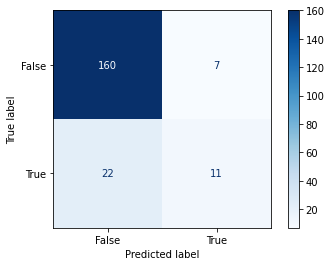

In [39]:
# Display confusion matrix for the test set

ConfusionMatrixDisplay.from_estimator(tree, X_test, Yb_test, cmap=plt.cm.Blues)
plt.show()

## Questions supplémentaires

**Q**: Quel approche d'optimisation semble produire les meilleurs résultats pour le problème étudié

Les deux semble équivalentes

**Q**: Répéter cette procédure en utilisant des arbre de régression (fonction `DecisionTreeRegressor`). \
Quelle approche conceptuelle (regression vs classification) semble produire les meilleurs résultats pour le problème étudié.

Meilleur score = 0.738090, Meilleur paramètre = {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 7}


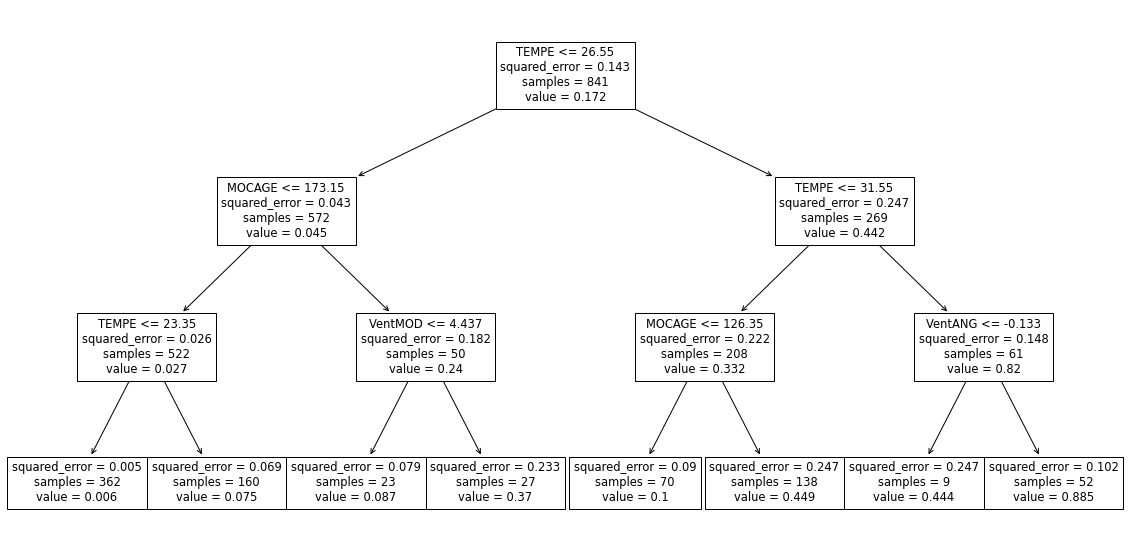

In [40]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV

# Optimisation de la profondeur de l'arbre,
#              du critère d'optimisation, et
#              du nombre minimum d'échantillon par feuille.
param = [{"max_depth": list(range(2, 10)),
          "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
          "min_samples_leaf": list(range(2, 10)),
          #"ccp_alpha": list(np.arange(0.001, 0.01, 0.001))
          }]

tree = GridSearchCV(DecisionTreeRegressor(), param, cv=10, n_jobs=-1)
treeOpt = tree.fit(X_train, Yb_train)

# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" %
      (1. - treeOpt.best_score_, treeOpt.best_params_))

# Arbre final
tree = treeOpt.best_estimator_

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_names)
plt.show()


In [41]:
X_train[1, :]

array([ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.01200000e+02,  2.02000000e+01,
        6.67608000e+00,  2.88590000e-01, -5.11266802e+00, -9.76128289e-02,
       -1.62455155e+00])

In [42]:
tree.predict(X_test)


array([0.44927536, 0.08695652, 0.00552486, 0.37037037, 0.00552486,
       0.00552486, 0.44927536, 0.075     , 0.44927536, 0.08695652,
       0.44927536, 0.44927536, 0.44927536, 0.37037037, 0.00552486,
       0.37037037, 0.44927536, 0.88461538, 0.88461538, 0.00552486,
       0.88461538, 0.00552486, 0.44927536, 0.1       , 0.00552486,
       0.1       , 0.08695652, 0.00552486, 0.44444444, 0.44927536,
       0.00552486, 0.00552486, 0.44927536, 0.00552486, 0.00552486,
       0.00552486, 0.1       , 0.075     , 0.075     , 0.075     ,
       0.88461538, 0.88461538, 0.44927536, 0.00552486, 0.1       ,
       0.00552486, 0.075     , 0.00552486, 0.075     , 0.00552486,
       0.00552486, 0.44927536, 0.00552486, 0.88461538, 0.44927536,
       0.075     , 0.44927536, 0.075     , 0.075     , 0.00552486,
       0.44927536, 0.00552486, 0.075     , 0.075     , 0.00552486,
       0.44444444, 0.075     , 0.44927536, 0.075     , 0.44927536,
       0.44927536, 0.00552486, 0.44927536, 0.00552486, 0.00552

**Q**: Les transformations des données appliquées au début de l'étude (log, sqrt) ont-elle eu une influence sur les résultats des arbres de régression/classification ? \
*Pour répondre à cette question, répéter les analyses sans transformer les données et comparer les résultats.* 

Discuter les observations faites.

**Q** Comparez les implémentations R et Python (temps d'exécution, rapidité de mise en oeuvre).

Quand préférer R ou Python?

**Q**: Pour les différentes approches testées, répondez aux questions suivantes:
    
- Parmis le nombre de total de jours de forte pollution à détecter, quel proportion ont bien été prédits par le modèle ? (Cette grandeur est appellée le rappel, _recall en anglais_)
- Parmis le nombre de total de jours prédits par le modèle comme étant à forte pollution , quel proportion s'est avérée correcte ? (Cette grandeur est appellée la précision)

À partir de ces résultats, que pouvez vous dire concernant le choix du meilleur modèle:
- Si on considère très dangereux de ne pas prévoir un dépassement de seuil ?
- Si l'on considère qu'une prédiction de dépassement de seuil _à tort_ coûte très cher à cause des mesures mises en place.